In [1]:
### Definining name of analysis ###
name = '2023-07-06_CREATeVTuningAccelerations'
data_path = '../data/'
data_folder = 'createv-2023-07-06'
file_name = '00000012.BIN'
datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

In [2]:
from os import sys
import os
sys.path.append('../')

# Getting packages #
%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize 
from scipy.io import savemat

import plotly.express as px

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

import data_exporter
import datetime

### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [3]:
# Setting Plot Defaults
plt.style.use('../basic_plotter.mplstyle')

In [4]:
# Importing data, specifying import characteristics, backing up results
rate = "10ms"
interpolateM = "linear"
processor = "CREATeV_2023"

rawdata_name = data_folder+'/'+file_name.split('.')[0]+'_'+rate+'_'+interpolateM+'_'+processor+'.pkl'

# Checking if the data is already pickled for analysis
if os.path.exists(data_path+rawdata_name):
    df = pd.read_pickle(data_path+rawdata_name)
else:
    df = main.get_data(processor, data_folder+'/'+file_name, rate)
    df = df.interpolate(method=interpolateM)
    pd.to_pickle(df, data_path+rawdata_name) # Storing parsed data

In [5]:
# Vehicle parameters
prop = propellers.aeronaut20x8() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.3 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
linus = airplane(mass, chord, span)

P_systems = 0.3 # Amount of power consumed by everything except the ESC & motor

highorderpolar = True

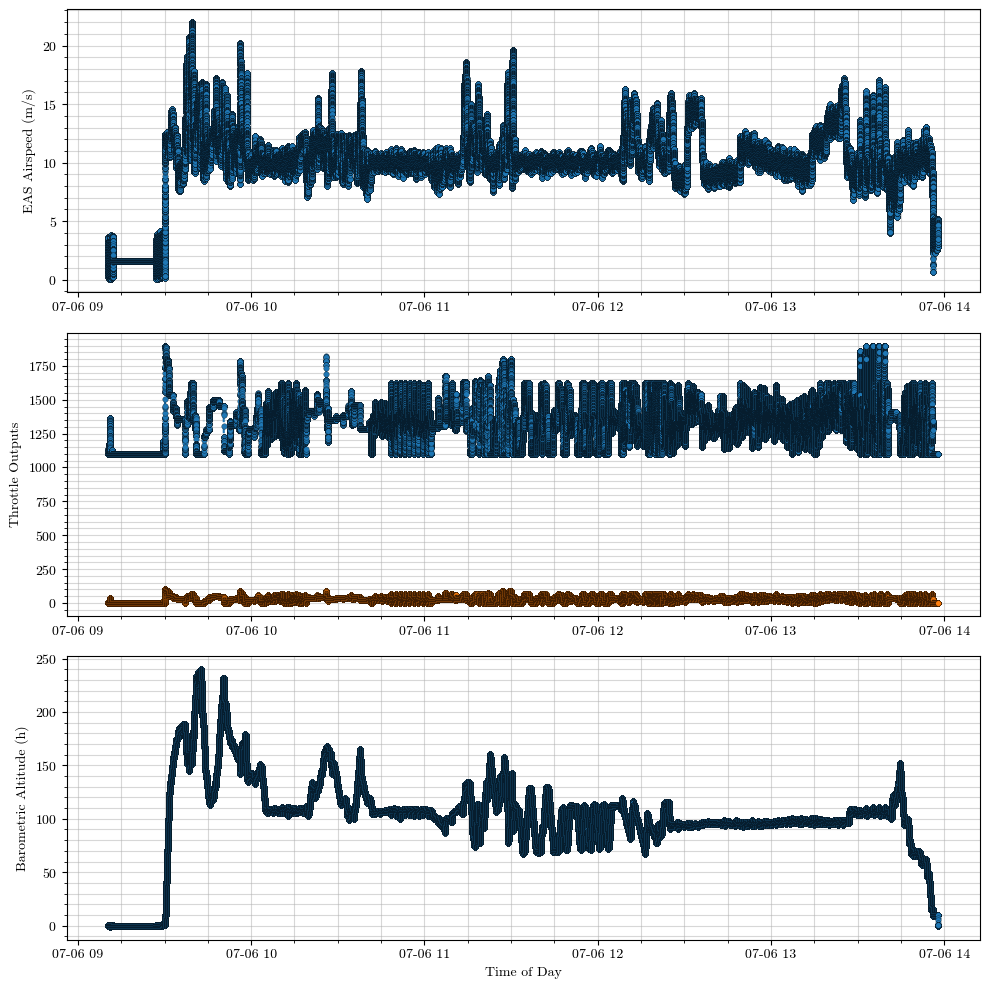

In [6]:
# Generating Plots
timeindex_v_thr_h = plt.figure(figsize=(10,10))

ax0 = plt.subplot(3,1,1)
plt.grid("On")
plt.plot(df.index, df.Airspeed_Sensor0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.ylabel("EAS Airspeed (m/s)")
ax1 = plt.subplot(3,1,2, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.ThrottleOut, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.plot(df.index, df.Throttle, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.ylabel("Throttle Outputs")
ax2 = plt.subplot(3,1,3, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.Altitude_BARO_0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.ylabel("Barometric Altitude (h)")
plt.xlabel("Time of Day")
plt.grid("On")
plt.show()

#main.save_figure(timeindex_v_thr_h, f'{timeindex_v_thr_h=}'.split('=')[0], figure_path)

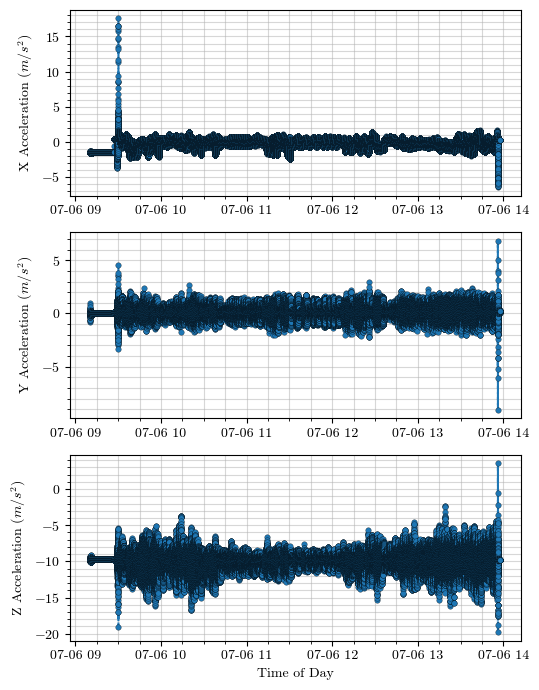

In [7]:
# Plotting raw IMU accelerations
raw_IMU0_accelerations = plt.figure(figsize=(5.5,7))
ax0 = plt.subplot(3,1,1)
plt.plot(df.index, df.XAcc_IMU0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.ylabel("X Acceleration $(m/s^2)$")
ax1 = plt.subplot(3,1,2, sharex=ax0)
plt.plot(df.index, df.YAcc_IMU0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.ylabel("Y Acceleration $(m/s^2)$")
ax2 = plt.subplot(3,1,3, sharex=ax0)
plt.plot(df.index, df.ZAcc_IMU0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.xlabel("Time of Day")
plt.ylabel("Z Acceleration $(m/s^2)$")
plt.show()

# main.save_figure(raw_IMU0_accelerations, f'{raw_IMU0_accelerations=}'.split('=')[0], figure_path)

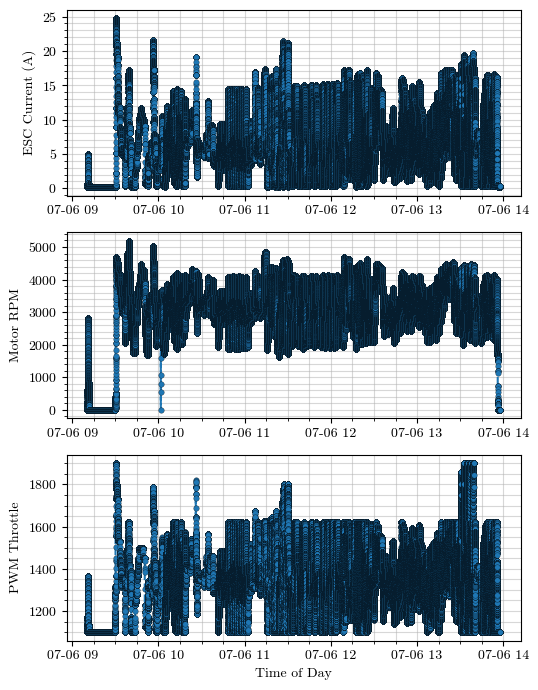

In [8]:
# Plotting Propulsion Information
timeindex_I_RPM_thr = plt.figure(figsize=(5.5,7))

ax0 = plt.subplot(3,1,1)
ax0.plot(df.index, df.MainBatteryCurrent, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
ax0.set_ylabel("ESC Current (A)")
ax1 = plt.subplot(3,1,2, sharex=ax0)
ax1.plot(df.index, df.MotorRPM, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
ax1.set_ylabel("Motor RPM")
ax2 = plt.subplot(3,1,3, sharex=ax0)
ax2.plot(df.index, df.ThrottleOut, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
ax2.set_ylabel("PWM Throttle")
ax2.set_xlabel("Time of Day")
plt.show()

#main.save_figure(timeindex_I_RPM_thr, f'{timeindex_I_RPM_thr=}'.split('=')[0], figure_path)

In [9]:
### Mask Initialization ###

# Generating Start/End Times for Segments #
# Producing mask_array for dataframe

# def get_mask(df, start, end, year, month, day):
#     # Getting boolean mask from start and end times
#     start_time = get_datetime(start, year, month, day)
#     end_time = get_datetime(end, year, month, day)
#     mask = (df.index > start_time) & (df.index < end_time)
#     return mask

# def get_datetime(hour_string, year, month, day):
#     # Results completed datetime from hour string, and date
#     split_nums = hour_string.split(':')
#     hours = int(split_nums[0])
#     minutes = int(split_nums[1])
#     seconds = int(split_nums[2])
#     return pd.Timestamp(year=year, month=month, day=day, hour=hours, minute=minutes, second=seconds)

year = 2023
month = 7
day = 6

# Acceleration Masking from the above figures
seg_times = np.array([['13:30:31','13:30:45'],
                      ['13:32:26','13:32:51'],
                      ['13:34:45','13:35:10'],
                      ['13:36:59','13:37:20'],
                      ['13:39:05','13:39:27']])
seg_zeroing = np.array([['9:15:00','9:25:00']])
mask_array = []
acc_masks = []
for i in range(np.shape(seg_times)[0]):
    mask = cl_finders.get_mask(df, seg_times[i,0], seg_times[i,1], year, month, day)
    mask_array.append(mask)
for i in range(np.shape(seg_zeroing)[0]):
    mask = cl_finders.get_mask(df, seg_zeroing[i,0], seg_zeroing[i,1], year, month, day)
    acc_masks.append(mask)

In [10]:
############# Main Analysis ###############3

# Gravity
g = 9.807

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
theta = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

# Atmospheric adjustments:
rho = df["Pressure_BARO0"].to_numpy() * (287 * (df["Temperature_ARSP"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                      # Altitude
Vd_eas = df["DescentRate"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1    # the true airspeed
gamma = np.arcsin(-Vd_tas/v_tas)
alpha = gamma + theta

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                      # Revolutions per second
i_esc = df["MainBatteryCurrent"].to_numpy()             # Really the ESC voltage and current here
v_esc = df["MainBatteryVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Inertial Measurement Unit
xp_acc = df.XAcc_IMU0.to_numpy()                       # Acceleration in X direction of the IMU
yp_acc = df.YAcc_IMU0.to_numpy()                       # Acceleration in Y direction of the IMU
zp_acc = df.ZAcc_IMU0.to_numpy()                       # Acceleration in Z direction of the IMU

U_dot = xp_acc - g * np.sin(theta)
V_dot = yp_acc + (9.807 * np.cos(theta) * np.sin(phi))
W_dot = zp_acc + g * np.cos(theta) * np.cos(phi)

gamma = np.arcsin(-Vd_tas/v_tas)
alpha = gamma + theta

U = v_tas * np.cos(alpha)
V = 0
W = v_tas * np.sin(alpha)

P = df.GyroX_IMU0 
Q = df.GyroY_IMU0
R = df.GyroZ_IMU0

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_21433/1462954479.py:11: RuntimeWarning: invalid value encountered in reciprocal
  rho = df["Pressure_BARO0"].to_numpy() * (287 * (df["Temperature_ARSP"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_21433/1462954479.py:13: RuntimeWarning: invalid value encountered in reciprocal
  v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_21433/1462954479.py:19: RuntimeWarning: invalid value encountered in reciprocal
  Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1    # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_21433/1462954479.py:20: RuntimeWarning: invalid value encountered in arcsin
  gamma = np.arcsin(-Vd_tas/v_tas)
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_21433/1462954479.py:27:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


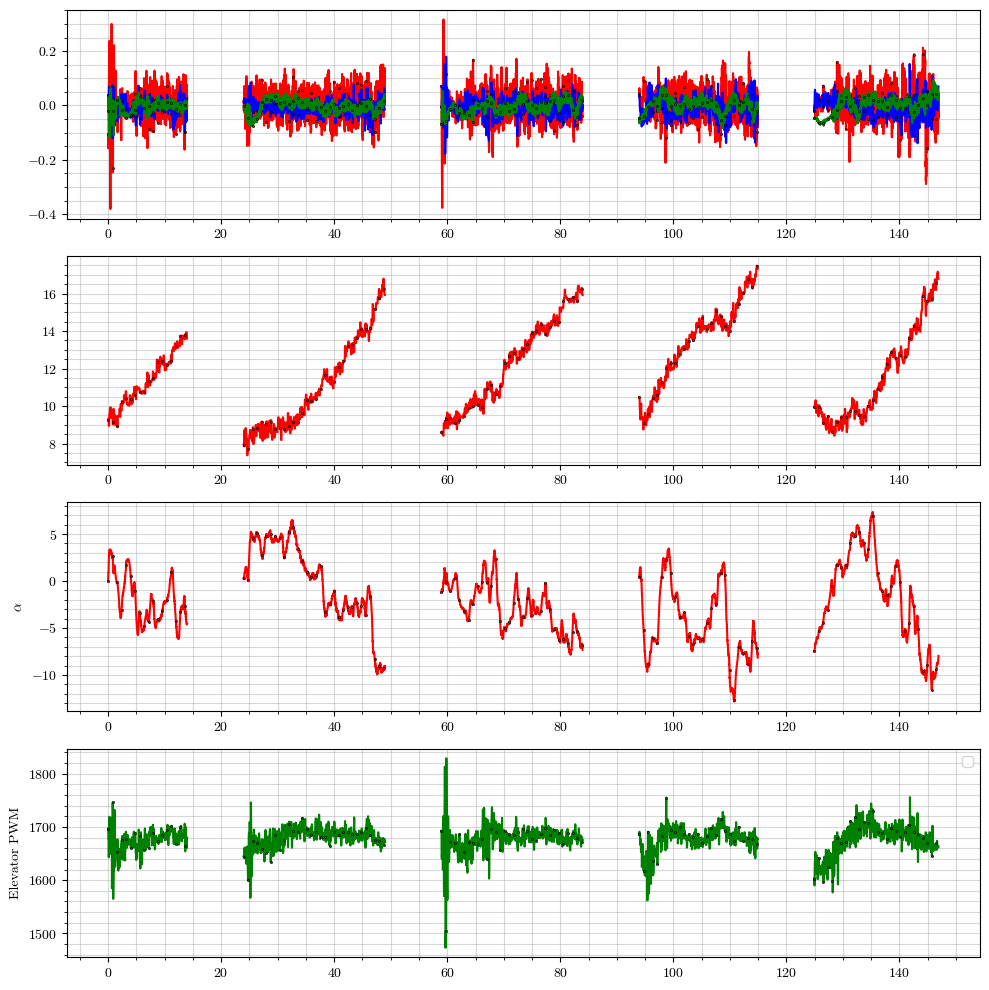

In [11]:
plt.figure(figsize=(10,10))
plt.tight_layout()
t_init = 0
markerevery=80
markedgew=0.5

ax1 = plt.subplot(4,1,1)
ax2 = plt.subplot(4,1,2, sharex=ax1)
ax3 = plt.subplot(4,1,3, sharex=ax1)
ax4 = plt.subplot(4,1,4, sharex=ax1)
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax1.plot(time_s, P[mask_array[i]], color='r', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='P')
    ax1.plot(time_s, Q[mask_array[i]], color='b', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='Q')
    ax1.plot(time_s, R[mask_array[i]], color='g', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='R')
    ax2.plot(time_s, v_tas[mask_array[i]], color='r', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax3.plot(time_s, np.rad2deg(alpha[mask_array[i]]), color='r', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax3.set_ylabel("$\\alpha$")
    ax4.plot(time_s, df.ElevatorOut[mask_array[i]], color='g', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax4.set_ylabel("Elevator PWM")
    t_init = time_s[-1]+10
plt.legend()
plt.show()

9.842799270283539
0.00021018870813517164


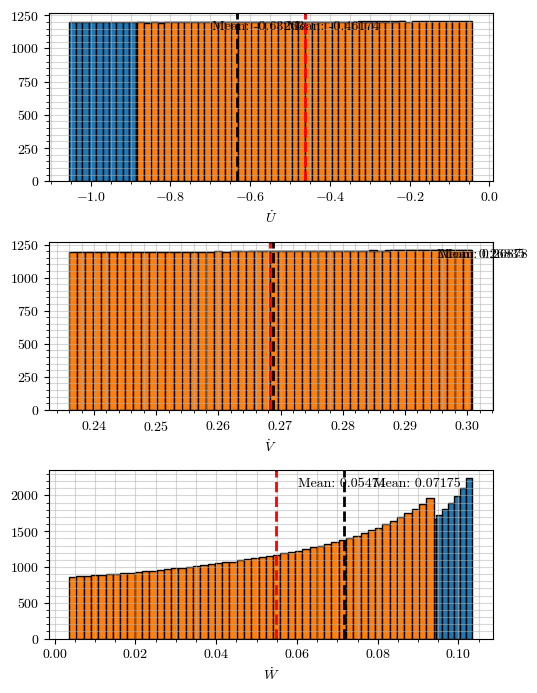

In [12]:
thetap = 1.0 * (np.pi/180)  # Pitch perturbation from IMU orientation (Degrees)
phip = 0.0 * (np.pi/180)  # Roll perturbation from IMU orientation (Degrees)
IMUtotal = np.sqrt(xp_acc**2 + yp_acc**2 + zp_acc**2)
print(np.mean(IMUtotal[acc_masks[0]]))
print(np.std(IMUtotal[acc_masks[0]]))

U_dot = xp_acc - np.mean(IMUtotal[acc_masks[0]]) * np.sin(theta)
V_dot = yp_acc + (np.mean(IMUtotal[acc_masks[0]]) * np.cos(theta) * np.sin(phi))
W_dot = zp_acc + np.mean(IMUtotal[acc_masks[0]]) * np.cos(theta) * np.cos(phi)

U_dotp = xp_acc - (np.mean(IMUtotal[acc_masks[0]]) * np.sin(theta+thetap))
V_dotp = yp_acc + (np.mean(IMUtotal[acc_masks[0]]) * np.cos(theta+thetap) * np.sin(phi+phip))
W_dotp = zp_acc + (np.mean(IMUtotal[acc_masks[0]]) * np.cos(theta+thetap) * np.cos(phi+phip))

def plot_hist(mask_array):

    plt.figure(figsize=(5.5, 7))
    plt.title("Body Accelerations in X Direction")
    i = 0
    ax0 = plt.subplot(3,1,1)
    ax0.hist(U_dotp[mask_array[i]], bins=50, edgecolor='k', label='Adjusted')
    ax0.hist(U_dot[mask_array[i]], bins=50, edgecolor='k', label='Original')
    ax0.axvline(np.mean(U_dotp[mask_array[i]]), color='k', linestyle='dashed', linewidth=2)
    ax0.axvline(np.mean(U_dot[mask_array[i]]), color='r', linestyle='dashed', linewidth=2)
    ax0.set_xlabel("$\dot{U}$")
    min_ylim, max_ylim = ax0.set_ylim()
    ax0.text(U_dotp[mask_array[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(U_dotp[mask_array[i]].mean()))
    ax0.text(U_dot[mask_array[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(U_dot[mask_array[i]].mean()))

    ax1 = plt.subplot(3,1,2)
    ax1.hist(V_dotp[mask_array[i]], bins=50, edgecolor='k', label='Adjusted')
    ax1.hist(V_dot[mask_array[i]], bins=50, edgecolor='k', label='Original')
    ax1.axvline(np.mean(V_dotp[mask_array[i]]), color='k', linestyle='dashed', linewidth=2)
    ax1.axvline(np.mean(V_dot[mask_array[i]]), color='r', linestyle='dashed', linewidth=2)
    ax1.set_xlabel("$\dot{V}$")
    min_ylim, max_ylim = ax1.set_ylim()
    ax1.text(V_dotp[mask_array[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(V_dotp[mask_array[i]].mean()))
    ax1.text(V_dot[mask_array[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(V_dot[mask_array[i]].mean()))

    ax2 = plt.subplot(3,1,3)
    ax2.hist(W_dotp[mask_array[i]], bins=50, edgecolor='k', label='Adjusted')
    ax2.hist(W_dot[mask_array[i]], bins=50, edgecolor='k', label='Original')
    ax2.axvline(np.mean(W_dotp[mask_array[i]]), color='k', linestyle='dashed', linewidth=2)
    ax2.axvline(np.mean(W_dot[mask_array[i]]), color='r', linestyle='dashed', linewidth=2)
    ax2.set_xlabel("$\dot{W}$")
    min_ylim, max_ylim = ax2.set_ylim()
    ax2.text(W_dotp[mask_array[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(W_dotp[mask_array[i]].mean()))
    ax2.text(W_dot[mask_array[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(W_dot[mask_array[i]].mean()))

    plt.show()
plot_hist(acc_masks)


In [13]:
# Beginning Power Required Calculation #
CT = prop.thrust_coeff(J)
T = CT * rho * n**2 * prop.diameter**4
P_req_t1 = (T * v_tas)
P_req_t2 = (mass * g * Vd_tas)
P_req_t3 = -(mass * U_dot * v_tas)
P_req_t4 = -(mass * W_dot * v_tas * alpha)

P_req_q = mass * v_tas * (Q*U*alpha - Q*W)
P_req_pr = mass * v_tas * (R*V - P*V)

P_req = P_req_t1 + P_req_t2 + P_req_t3
P_req_r1 = P_req_t1 + P_req_t2 + P_req_t3 + P_req_t4
P_req_r2 = P_req_t1 + P_req_t2 + P_req_t3 + P_req_t4 + P_req_q + P_req_pr

D = P_req / v_tas
D_r1 = P_req_r1 / v_tas
D_r2 = P_req_r2 / v_tas

L = mass * (U_dotp * alpha - W_dotp) + (mass * g) - (T * alpha)

CD = D / (0.5 * rho * v_tas**2 * linus.area) # still need to estimate the wing area of linus
CD_r1 = D_r1 / (0.5 * rho * v_tas**2 * linus.area) # still need to estimate the wing area of linus
CD_r2 = D_r2 / (0.5 * rho * v_tas**2 * linus.area) # still need to estimate the wing area of linus
CL = cl_finders.cl_usbanked(linus, q, phi, W_dot)
CL_exp = L / (0.5 * rho * v_tas**2 * linus.area)

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:44: RuntimeWarning: invalid value encountered in reciprocal
  CL = ((aircraft.weight / np.cos(phi)) - (aircraft.mass * W_dot)) * (q * aircraft.area)**-1


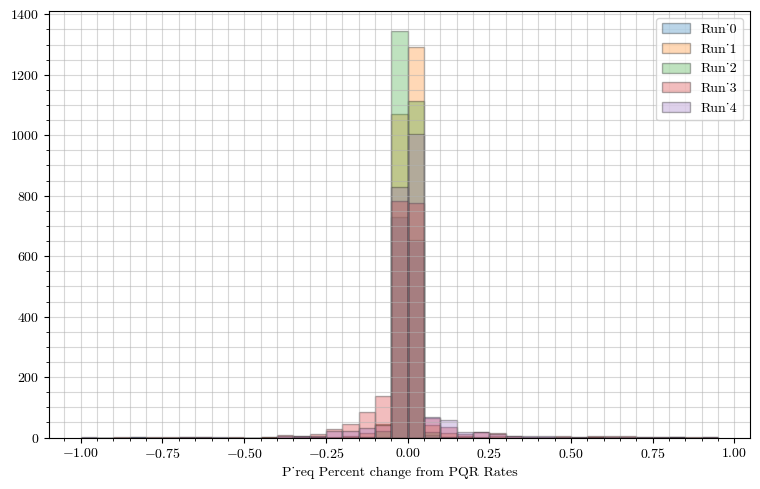

In [14]:
# Plotting the percent change from the PQR rates in the transient response
fig = plt.figure(figsize=(7.7,5))
ax = plt.subplot(1,1,1)
percent_change = 100 * (P_req_r2 - P_req_r1) / P_req_r1
for i in range(len(mask_array)):
    ax.hist(percent_change[mask_array[i]], bins=np.arange(-1, 1, 0.05), edgecolor=[0,0,0], label='Run_'+str(i), alpha=0.3)
plt.xlabel("P_req Percent change from PQR Rates")
plt.legend()
plt.show()

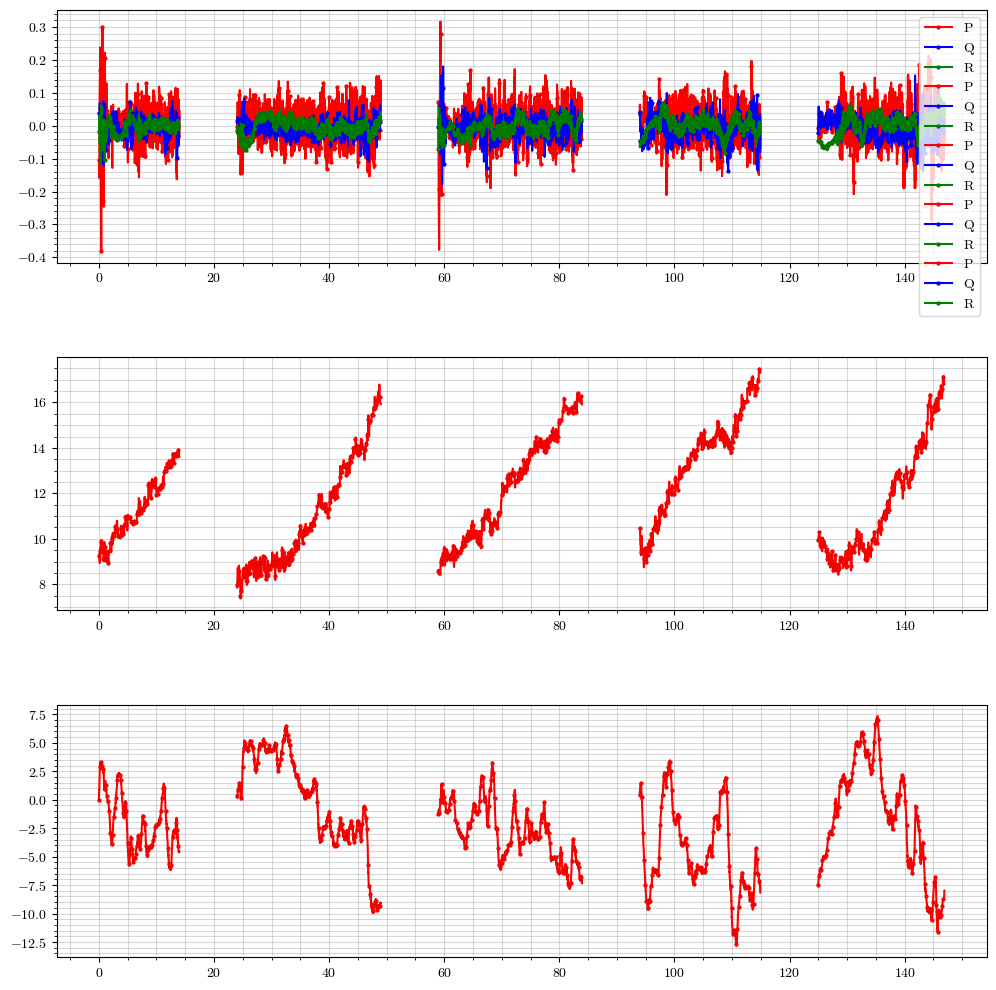

In [15]:
# Plotting the Rotational Rates
markerstyle = 'o'
markerevery = 20
markedgew = 0.05

t_init = 0

plt.figure(figsize=(10,10))
plt.tight_layout()
t_init = 0

ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2, sharex=ax1)
ax3 = plt.subplot(3,1,3, sharex=ax1)
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax1.plot(time_s, P[mask_array[i]], color='r', marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='P')
    ax1.plot(time_s, Q[mask_array[i]], color='b', marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='Q')
    ax1.plot(time_s, R[mask_array[i]], color='g', marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='R')
    ax2.plot(time_s, v_tas[mask_array[i]], color='r', marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax3.plot(time_s, np.rad2deg(alpha[mask_array[i]]), color='r', marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.grid(True)
ax2.grid(True)
ax1.legend()
plt.show()

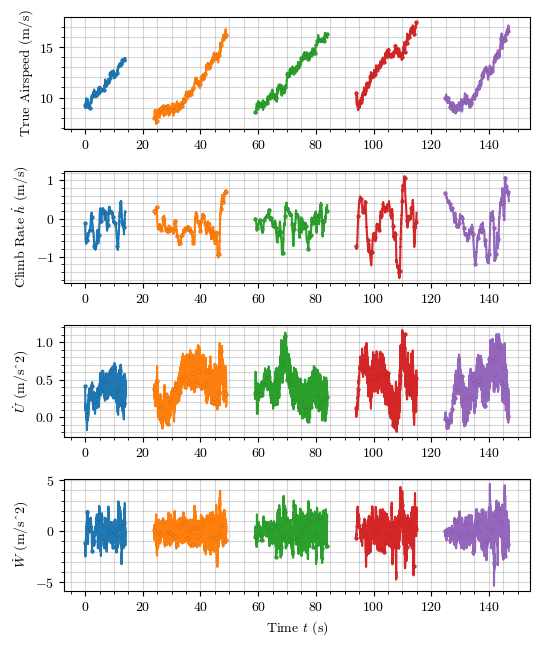

In [16]:
# Plotting Masked Acceleration Run Variables
markerstyle = 'o'
markerevery = 80
markedgew = 0.05
plt.figure(figsize=(5.5,6.5))
ax1 = plt.subplot(4,1,1)
t_init = 0
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax1.plot(time_s, v_tas[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("True Airspeed (m/s)")

ax0 = plt.subplot(4,1,2, sharex=ax1)
t_init = 0
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax0.plot(time_s, Vd_tas[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("Climb Rate $\dot{h}$ (m/s)")

ax2 = plt.subplot(4,1,3, sharex=ax1)
t_init = 0
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax2.plot(time_s, U_dot[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("$\dot{U}$ (m/s^2)")

ax3 = plt.subplot(4,1,4, sharex=ax1)
t_init = 0
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax3.plot(time_s, W_dot[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("$\dot{W}$ (m/s^2)")
ax3.set_xlabel("Time $t$ (s)")
plt.show()

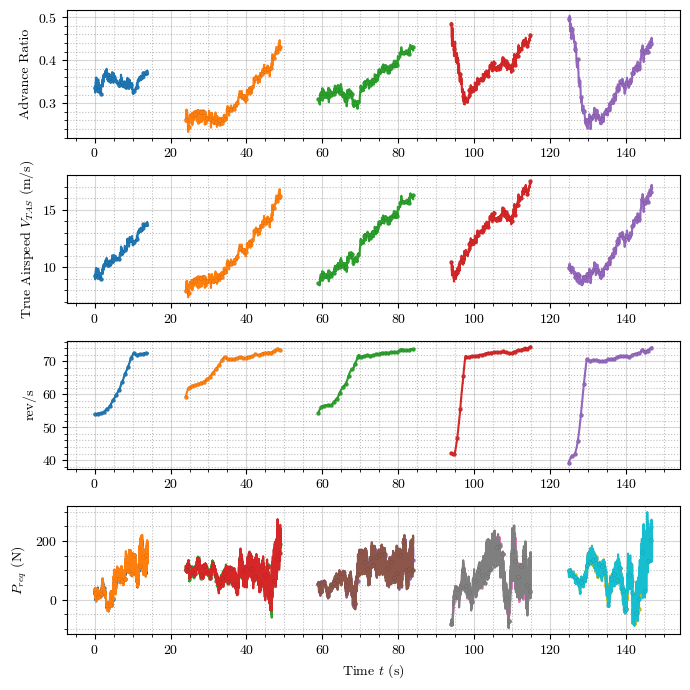

In [17]:
# Plotting Acceleration Runs
markerstyle = 'o'
markerevery = 80
markedgew = 0.05
plt.figure(figsize=(7,7))
ax1 = plt.subplot(4,1,1)
t_init = 0
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax1.plot(time_s, J[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("Advance Ratio")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')

ax0 = plt.subplot(4,1,2, sharex=ax1)
t_init = 0
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax0.plot(time_s, v_tas[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("True Airspeed $V_{TAS}$ (m/s)")
ax0.grid(which='major', linestyle='-')
ax0.grid(which='minor', linestyle=':', color='grey')

ax2 = plt.subplot(4,1,3, sharex=ax1)
t_init = 0
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax2.plot(time_s, n[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("rev/s")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')

ax3 = plt.subplot(4,1,4, sharex=ax1)
t_init = 0
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax3.plot(time_s, P_req[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax3.plot(time_s, P_req_r2[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='Angle of Attack Rotated')
    t_init = time_s[-1]+10
#ax3.legend()
ax3.set_ylabel("$P_{req}$ (N)")
ax3.set_xlabel("Time $t$ (s)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')

plt.show()

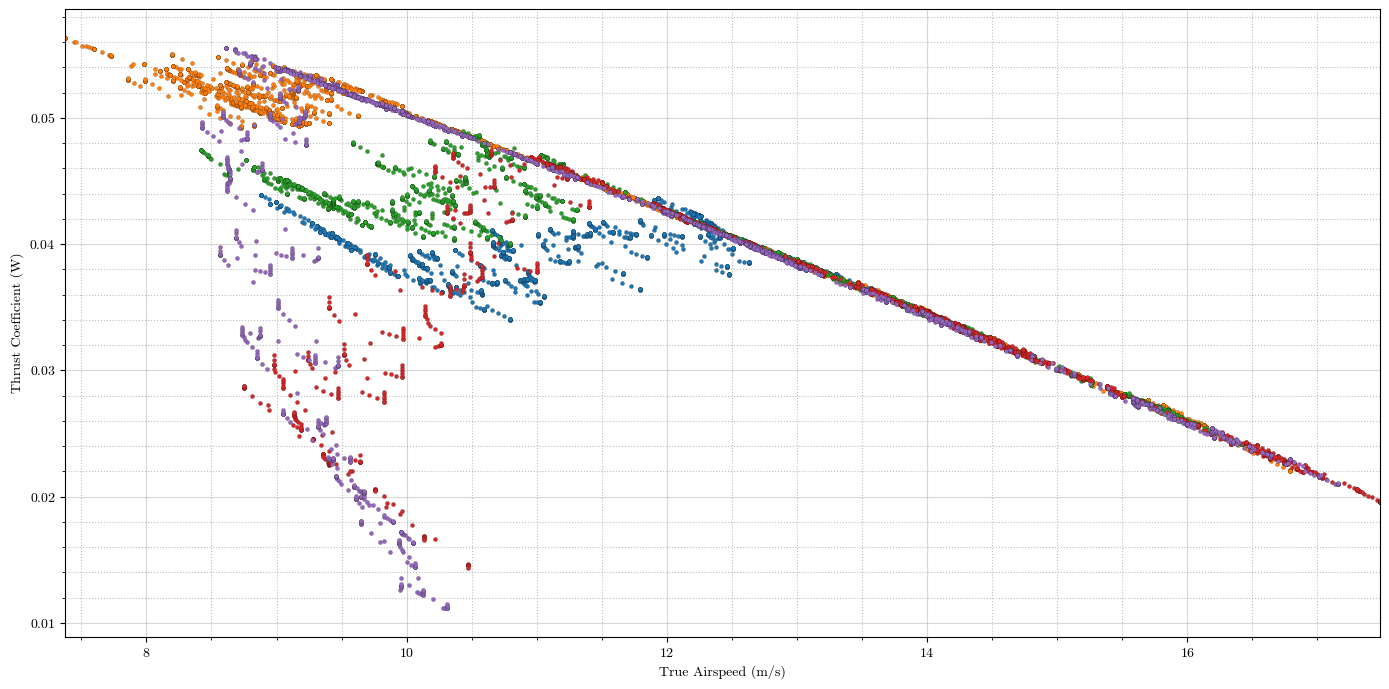

In [18]:
markerstyle = 'o'
markerevery = 1
markedgew = 0.1
plt.figure(figsize=(14,7))
ax1 = plt.subplot(1,1,1)
for i in range(len(mask_array)):
    ax1.plot(v_tas[mask_array[i]], CT[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
ax1.set_ylabel("Thrust Coefficient (W)")
ax1.set_xlabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)
plt.show()

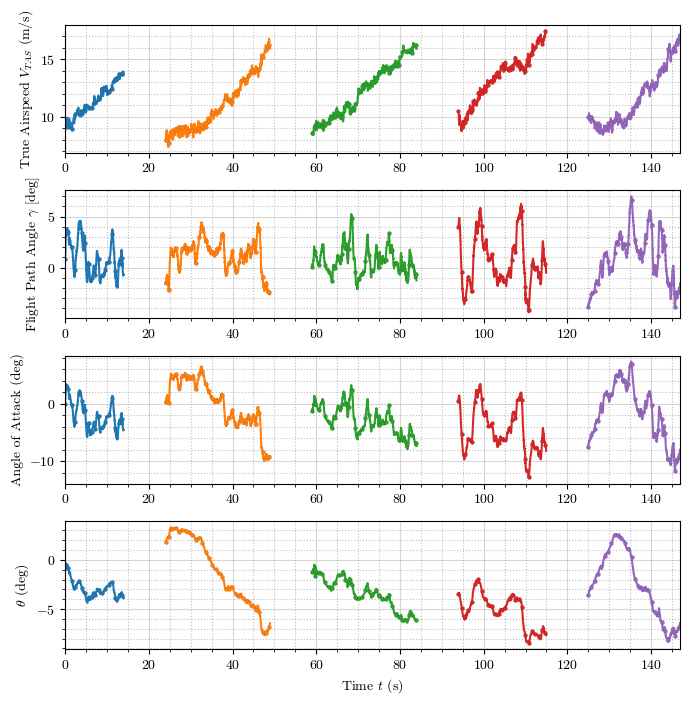

In [19]:
# Plotting Angle of Attack Parameters
markerstyle = 'o'
markerevery = 80
markedgew = 0.05
plt.figure(figsize=(7,7))
ax1 = plt.subplot(4,1,1)
t_init = 0
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax1.plot(time_s, v_tas[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("True Airspeed $V_{TAS}$ (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax0 = plt.subplot(4,1,2, sharex=ax1)
t_init = 0
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax0.plot(time_s, np.rad2deg(gamma[mask_array[i]]), marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("Flight Path Angle $\gamma$ [deg]")
ax0.grid(which='major', linestyle='-')
ax0.grid(which='minor', linestyle=':', color='grey')
ax0.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(4,1,3, sharex=ax1)
t_init = 0
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax2.plot(time_s, np.rad2deg(alpha[mask_array[i]]), marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("Angle of Attack (deg)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

ax3 = plt.subplot(4,1,4, sharex=ax1)
t_init = 0
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax3.plot(time_s, np.rad2deg(theta[mask_array[i]]), marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("$\\theta$ (deg)")
ax3.set_xlabel("Time $t$ (s)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()

In [20]:
# Removing elliptical lift CD 
def rem_ellipticalperf(CL, CD, airplane):

    CD_nell = CD - (CL**2 * (np.pi * airplane.AR)**-1)
    return CD_nell

In [21]:
# Work in progress!
# Getting Drag and Lift Coefficients for the correct moments in the flight

# Collecting all raw datapoints in various segments

# Complete dataset
cl_total = cl_finders.collect_segments_boolean(CL, mask_array)
cd_total = cl_finders.collect_segments_boolean(CD_r2, mask_array)

# Throttle ramp over 20 seconds dataset
cl_total_period20 = cl_finders.collect_segments_boolean(CL, mask_array, selection=[0,1,2])
cd_total_period20 = cl_finders.collect_segments_boolean(CD_r2, mask_array, selection=[0,1,2])

# Throttle ramp over 5/7.5 seconds dataset
cl_total_period5 = cl_finders.collect_segments_boolean(CL, mask_array, selection=[3, 4])
cd_total_period5 = cl_finders.collect_segments_boolean(CD_r2, mask_array, selection=[3, 4])

# Collecting bins 
bins = np.linspace(0.05, 1.4, 50)

[cl_means, cl_stds, cl_ci95s, cd_means, cd_stds, cd_ci95s] = cl_finders.collect_bins(bins, cl_total, cd_total)
[cl_means, cl_stds, cl_ci95s, cd_means, cd_stds, cd_ci95s] = cl_finders.collect_bins(bins, cl_total_period20, cd_total_period20)
[cl_means, cl_stds, cl_ci95s, cd_means, cd_stds, cd_ci95s] = cl_finders.collect_bins(bins, cl_total_period5, cd_total_period5)


TypeError: 'list' object cannot be interpreted as an integer

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_21433/1087051616.py:15: RuntimeWarning: Mean of empty slice.
  cl_means = [cl_total[digitized == i].mean() for i in range(1, len(bins))]
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_21433/1087051616.py:16: RuntimeWarning: Mean of empty slice.
  cd_means = [cdaoa_total[digitized == i].mean() for i in range(1, len(bins))]
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_21433/1087051616.py:26: RuntimeWarning: Mean of empty slice.
  cl_means_1 = [cl_total_1[digitized == i].mean() for i in range(1, len(bins))]
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_21433/1087051616.py:27: RuntimeWarning: Mean of empty slice.
  cd_means_1 = [cd_total_1[digitized == i].mean() for i in range(1, len(bin

[0.02542926 0.19954889 0.39381803]
[0.01441807 0.40581258]
Plot already exists


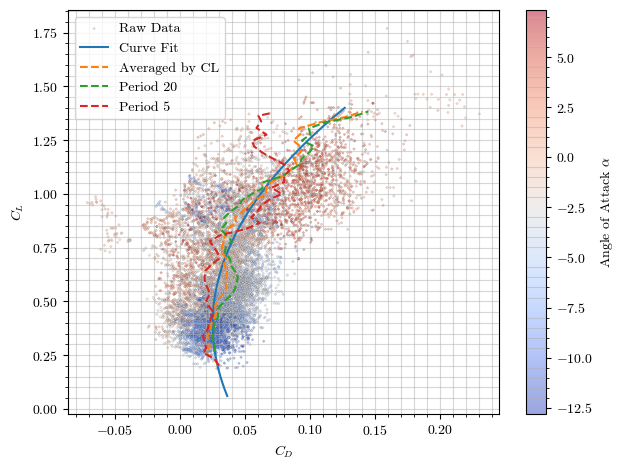

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_21433/1087051616.py:79: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Angle of Attack $\\alpha$')


Plot already exists


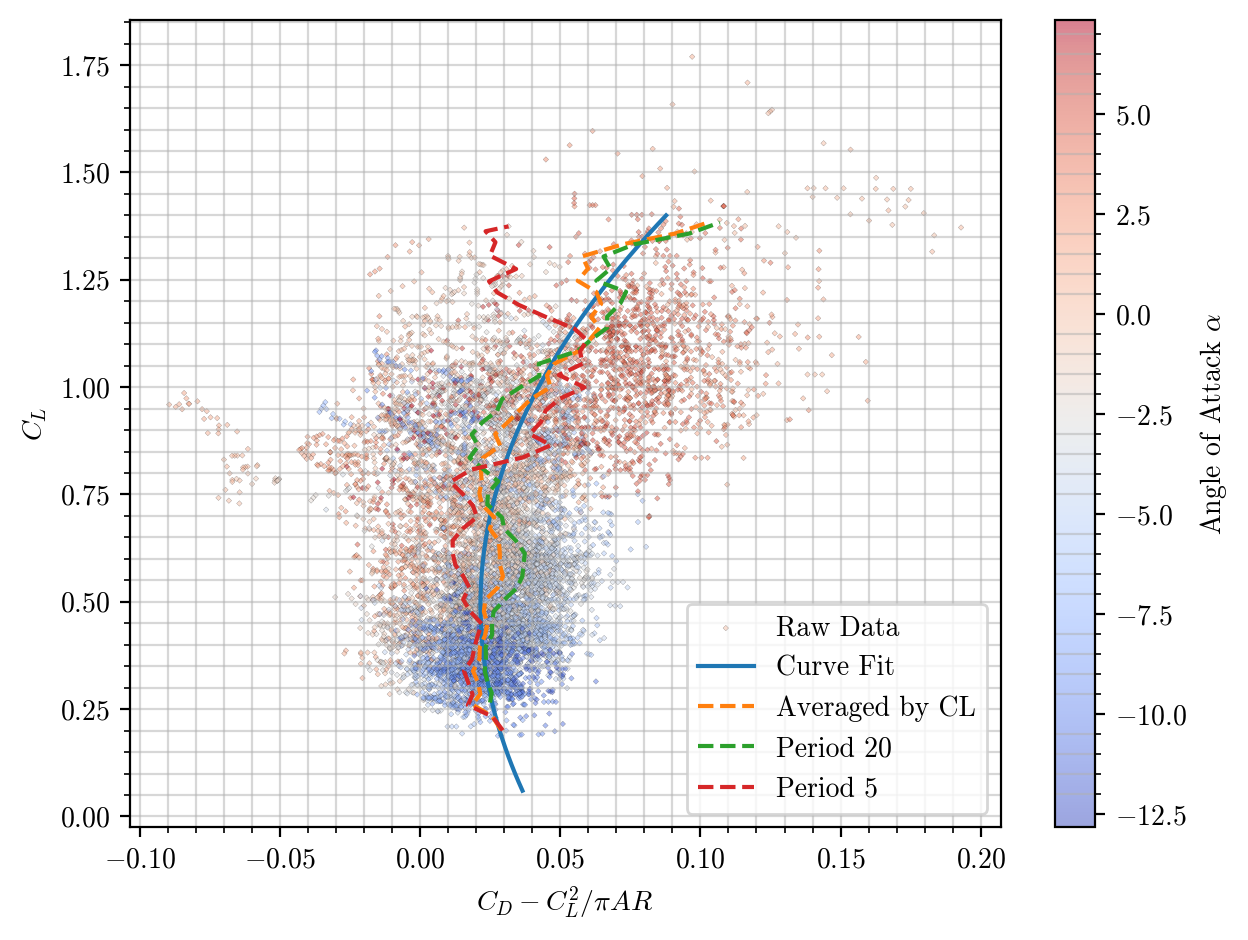

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_21433/1087051616.py:102: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Angle of Attack $\\alpha$')


Plot already exists


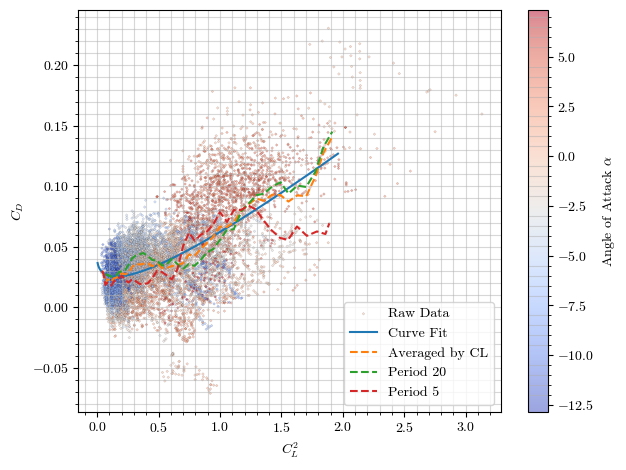

In [24]:
# Getting Drag and Lift Coefficients for the correct moments in the flight

bins = np.linspace(0.05, 1.4, 50)

cl_total = np.array([])
cd_total = np.array([])
cdaoa_total = np.array([])
aoa_total = np.array([])
for i in range(len(mask_array)):
    cl_total = np.append(cl_total, CL[mask_array[i]])
    cd_total = np.append(cd_total, CD[mask_array[i]])
    cdaoa_total = np.append(cdaoa_total, CD_r2[mask_array[i]])
    aoa_total = np.append(aoa_total, alpha[mask_array[i]])
digitized = np.digitize(cl_total, bins)
cl_means = [cl_total[digitized == i].mean() for i in range(1, len(bins))]
cd_means = [cdaoa_total[digitized == i].mean() for i in range(1, len(bins))]

# Period 20
cl_total_1 = np.array([])
cd_total_1 = np.array([])
selection = [0, 1, 2]
for i in selection:
    cl_total_1 = np.append(cl_total_1, CL[mask_array[i]])
    cd_total_1 = np.append(cd_total_1, CD_r2[mask_array[i]])
digitized = np.digitize(cl_total_1, bins)
cl_means_1 = [cl_total_1[digitized == i].mean() for i in range(1, len(bins))]
cd_means_1 = [cd_total_1[digitized == i].mean() for i in range(1, len(bins))]

# Period 5
cl_total_2 = np.array([])
cd_total_2 = np.array([])
selection = [3, 4]
for i in selection:
    cl_total_2 = np.append(cl_total_2, CL[mask_array[i]])
    cd_total_2 = np.append(cd_total_2, CD_r2[mask_array[i]])
digitized = np.digitize(cl_total_2, bins)
cl_means_2 = [cl_total_2[digitized == i].mean() for i in range(1, len(bins))]
cd_means_2 = [cd_total_2[digitized == i].mean() for i in range(1, len(bins))]

# savemat('../Results/cl_total.mat', {'cl_total': cl_total})
# savemat('../Results/cd_total.mat', {'cd_total': cd_total})
polar_acceleration = cl_finders.cd2polar(linus, cdaoa_total, cl_total, highorder=True)
polar_acceleration_lo = cl_finders.cd2polar(linus, cd_total, cl_total, highorder=False)

polar_2021 = pd.read_pickle('../Results/2022-06-15_ct.pkl')
polar_2022_ct = np.array([polar_2021.Polar[0], polar_2021.Polar[1], polar_2021.Polar[2]])

# #polar_acceleration[1] = 0.9
print(polar_acceleration)
print(polar_acceleration_lo)

CL_fitted, CD_fitted = cl_finders.plotfittedpolar(linus, polar_acceleration, np.array([0.06, 1.4]))
CL_2022, CD_2022 = cl_finders.plotfittedpolar(linus, polar_2022_ct, np.array([0.06, 1.4]))
# plt.figure()
# plt.plot(cd_total_1, cl_total_1, marker='d', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew, linestyle='')
# plt.plot(cdgood_means, clgood_means, marker='s', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew, linestyle='')
# plt.show()

fig_dragpolar = plt.figure()
plt.scatter(cdaoa_total, cl_total, c=np.rad2deg(aoa_total), cmap='coolwarm', marker='D', alpha=0.5, edgecolors=[0,0,0], s=2, linewidths=0.1, label='Raw Data')
plt.plot(CD_fitted, CL_fitted, marker='', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew, linestyle='-', label='Curve Fit')
plt.plot(cd_means, np.array(cl_means), marker='', markeredgecolor=[0,0,0], markersize=5, markeredgewidth=markedgew, linestyle='--', label='Averaged by CL')
plt.plot(cd_means_1, np.array(cl_means_1), marker='', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew, linestyle='--', label='Period 20')
plt.plot(cd_means_2, np.array(cl_means_2), marker='', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew, linestyle='--', label='Period 5')
plt.legend()
plt.colorbar(label='Angle of Attack $\\alpha$')
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
main.save_figure(fig_dragpolar, f'{fig_dragpolar=}'.split('=')[0], figure_path)
plt.show()

fig_dragpolarnell = plt.figure(dpi=200)
plt.scatter(rem_ellipticalperf(cl_total, cdaoa_total, linus), cl_total, c=np.rad2deg(aoa_total), cmap='coolwarm', marker='D', alpha=0.5, edgecolors=[0,0,0], s=2, linewidths=0.1, label='Raw Data')
plt.plot(rem_ellipticalperf(CL_fitted, CD_fitted, linus), CL_fitted, marker='', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew, linestyle='-', label='Curve Fit')
plt.plot(rem_ellipticalperf(np.array(cl_means), cd_means, linus), np.array(cl_means), marker='', markeredgecolor=[0,0,0], markersize=5, markeredgewidth=markedgew, linestyle='--', label='Averaged by CL')
plt.plot(rem_ellipticalperf(np.array(cl_means_1), cd_means_1, linus), np.array(cl_means_1), marker='', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew, linestyle='--', label='Period 20')
plt.plot(rem_ellipticalperf(np.array(cl_means_2), cd_means_2, linus), np.array(cl_means_2), marker='', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew, linestyle='--', label='Period 5')
plt.legend()
plt.colorbar(label='Angle of Attack $\\alpha$')
plt.xlabel("$C_D - C_L^2 / \pi AR$")
plt.ylabel("$C_L$")
main.save_figure(fig_dragpolarnell, f'{fig_dragpolarnell=}'.split('=')[0], figure_path)
plt.show()

# plt.figure()
# plt.plot(cd_total, cl_total, marker=markerstyle, alpha=0.5, markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew, linestyle='')
# plt.plot(cdaoa_total, cl_total, marker='D', alpha=0.5, markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew, linestyle='')
# plt.plot(CD_fitted, CL_fitted, marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew, linestyle='-')
# plt.plot(cd_means, cl_means, marker=markerstyle, markeredgecolor=[0,0,0], markersize=5, markeredgewidth=markedgew, linestyle='')
# #plt.plot(cdgood_means, clgood_means, marker='s', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew, linestyle='')
# plt.plot(CD_2021, CL_2021, marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew, linestyle='-')
# plt.show()
P_acc, EAS = cl_finders.polar2preqew(linus, polar_acceleration, (9,28), createvstandardweight=False)

fig_linearpolar = plt.figure()
plt.scatter(cl_total**2,cdaoa_total, c=np.rad2deg(aoa_total), cmap='coolwarm', marker='D', alpha=0.5, edgecolors=[0,0,0], s=2, linewidths=0.1, label='Raw Data')
plt.plot(CL_fitted**2, CD_fitted, marker='', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew, linestyle='-', label='Curve Fit')
plt.plot(np.array(cl_means)**2, cd_means, marker='', markeredgecolor=[0,0,0], markersize=5, markeredgewidth=markedgew, linestyle='--', label='Averaged by CL')
plt.plot(np.array(cl_means_1)**2, cd_means_1, marker='', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew, linestyle='--', label='Period 20')
plt.plot(np.array(cl_means_2)**2, cd_means_2, marker='', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew, linestyle='--', label='Period 5')
plt.legend()
plt.colorbar(label='Angle of Attack $\\alpha$')
plt.ylabel("$C_D$")
plt.xlabel("$C_L ^2$")
main.save_figure(fig_linearpolar, f'{fig_linearpolar=}'.split('=')[0], figure_path)
plt.show()

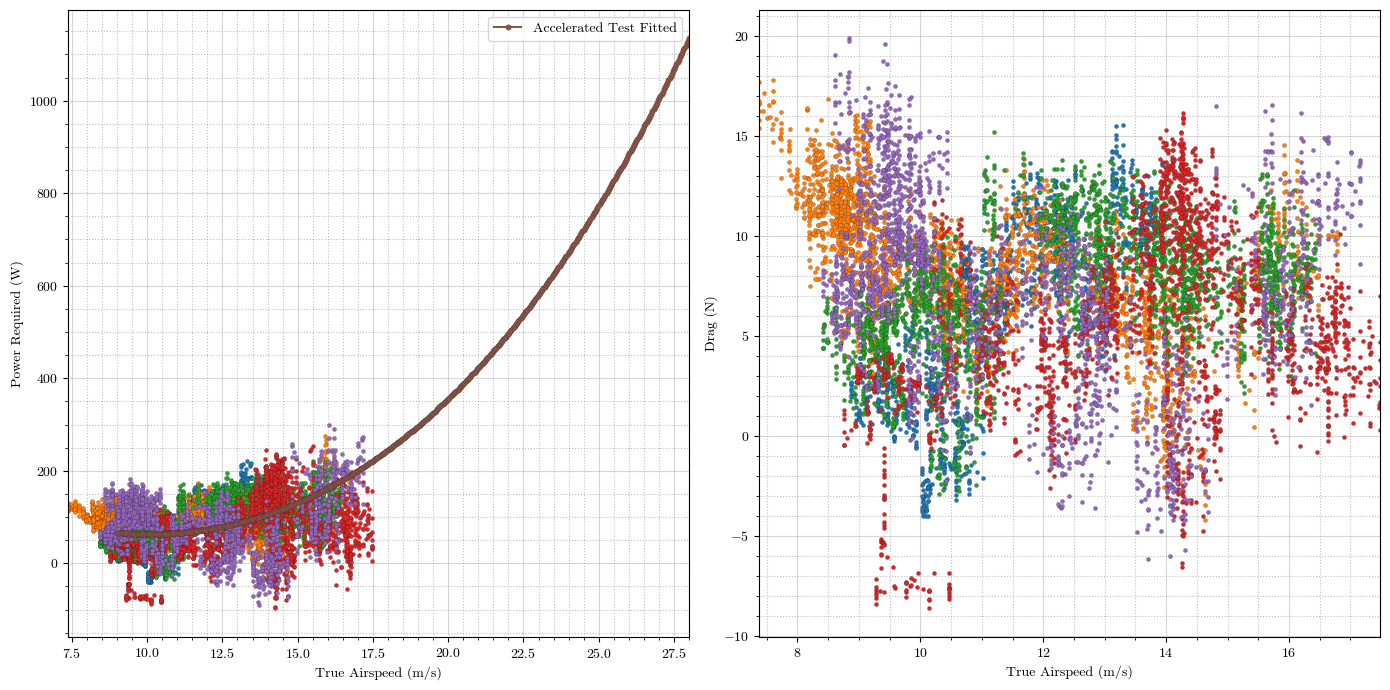

In [25]:
# Overplotting the results of the 6 Accelerations #

markerstyle = 'o'
markerevery = 1
markedgew = 0.1
plt.figure(figsize=(14,7))
ax1 = plt.subplot(1,2,1)
for i in range(len(mask_array)):
    ax1.plot(v_tas[mask_array[i]], P_req_r2[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
#ax1.plot(V_xflr, P_xflr, marker=markerstyle, markeredgecolor=[0,0,0], markersize=4, markevery=markerevery, markeredgewidth=markedgew, linestyle='-', label='XFLR Bare Wing')
ax1.plot(EAS, P_acc, marker=markerstyle, markeredgecolor=[0,0,0], markersize=4, markevery=markerevery, markeredgewidth=markedgew, linestyle='-', label='Accelerated Test Fitted')
ax1.set_ylabel("Power Required (W)")
ax1.set_xlabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.legend()
ax1.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(1,2,2)
for i in range(len(mask_array)):
    ax2.plot(v_tas[mask_array[i]], D[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
ax2.set_ylabel("Drag (N)")
ax2.set_xlabel("True Airspeed (m/s)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()
plt.show()

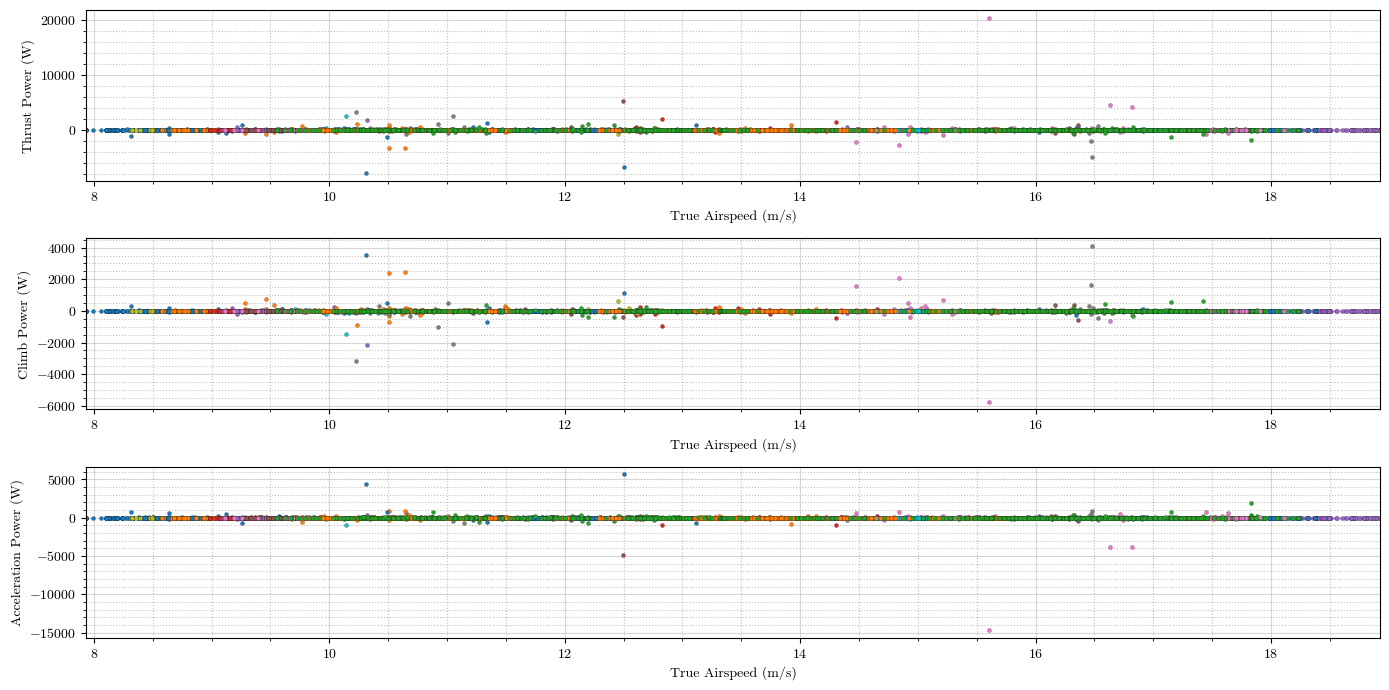

In [ ]:
# Plotting all terms of power required to see significance

markerstyle = 'o'
markerevery = 1
markedgew = 0.1
plt.figure(figsize=(14,7))
ax1 = plt.subplot(3,1,1)
for i in range(len(mask_array)):
    ax1.plot(v_tas[mask_array[i]], P_req_t1[mask_array[i]]/P_req[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
ax1.set_ylabel("Thrust Power (W)")
ax1.set_xlabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(3,1,2,sharex=ax1)
for i in range(len(mask_array)):
    ax2.plot(v_tas[mask_array[i]], P_req_t2[mask_array[i]]/P_req[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
ax2.set_ylabel("Climb Power (W)")
ax2.set_xlabel("True Airspeed (m/s)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

ax3 = plt.subplot(3,1,3, sharex=ax1)
for i in range(len(mask_array)):
    ax3.plot(v_tas[mask_array[i]], P_req_t3[mask_array[i]]/P_req[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
ax3.set_ylabel("Acceleration Power (W)")
ax3.set_xlabel("True Airspeed (m/s)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)

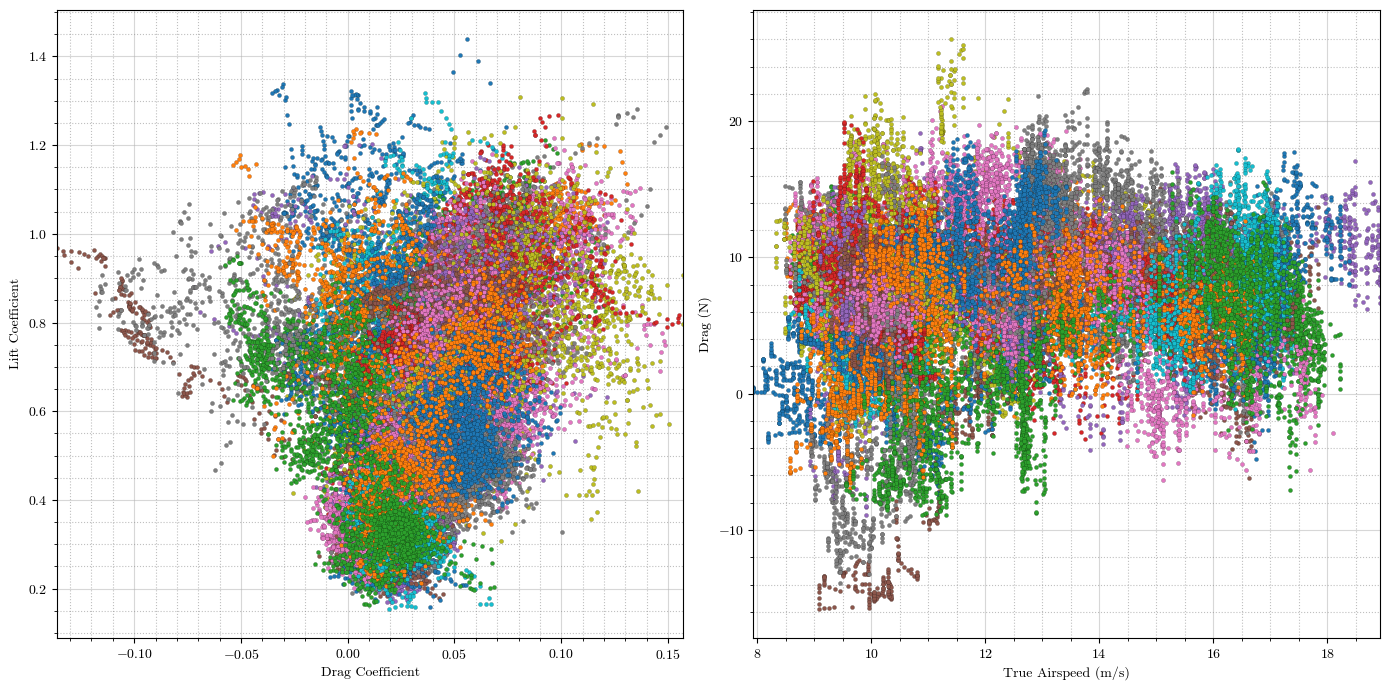

In [ ]:
# Plotting the drag polar of the Vehicle

markerstyle = 'o'
markerevery = 1
markedgew = 0.1
plt.figure(figsize=(14,7))
ax1 = plt.subplot(1,2,1)
for i in range(len(mask_array)):
    ax1.plot(CD_r2[mask_array[i]], CL[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
ax1.set_ylabel("Lift Coefficient")
ax1.set_xlabel("Drag Coefficient")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(1,2,2)
for i in range(len(mask_array)):
    ax2.plot(v_tas[mask_array[i]], D[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
ax2.set_ylabel("Drag (N)")
ax2.set_xlabel("True Airspeed (m/s)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()
plt.show()

In [ ]:
# Collecting all CL, CD data points for cruising, plotting with better visuals

# Cruise drag data
cd_total_eta = cl_finder.total_segments_boolean(CD, mask)
cd_total_ct = cl_finder.total_segments_boolean(Cd_ct, mask)
# Cruise lift data
cl_total_cruise = cl_finder.total_segments_boolean(CL, mask)

# Binning averages
bins = np.linspace(0.05, 1.4, 51)

# Lift binning/averaging
cl_means_cruise = [cl_total_cruise[digitized_cruise == i].mean() for i in range(1, len(bins))]
cl_means_desc = [cl_total_desc[digitized_desc == i].mean() for i in range(1, len(bins))]
# Drag averaging
cd_means_eta = [cd_total_eta[digitized_cruise == i].mean() for i in range(1, len(bins))]
cd_means_ct = [cd_total_ct[digitized_cruise == i].mean() for i in range(1, len(bins))]
cd_means_desc = [cd_total_desc[digitized_desc == i].mean() for i in range(1, len(bins))]

raw_ave_polarw_confint = plt.figure(figsize=(5,5), dpi=150)
plt.plot(cd_total_eta, cl_total_cruise, linestyle='', marker='.', color = 'blue', alpha = 0.2, label='$\eta$ Total')
plt.plot(cd_total_ct, cl_total_cruise, linestyle='', marker='.', color='orange', alpha = 0.2, label='$C_T$ Total')
plt.plot(cd_total_desc, cl_total_desc, linestyle='', marker='.', color ='red', alpha = 0.2, label='$\dot{h}$ Total')
plt.plot(cd_means_eta, cl_means_cruise, linestyle='--', color='blue', marker='', label='$\eta$ Method')
plt.plot(cd_means_ct, cl_means_cruise, linestyle='--', color='orange', marker='', label='$C_T$ Method')
plt.plot(cd_means_desc, cl_means_desc, linestyle='--', color='red', marker='', label='$\dot{h}$ Method')
plt.fill_betweenx(cl_means_cruise, np.array(cd_means_eta) - np.array(cd_ci95_eta), np.array(cd_means_eta) + np.array(cd_ci95_eta), color='blue', alpha=0.2)
plt.fill_betweenx(cl_means_cruise, np.array(cd_means_ct) - np.array(cd_ci95_ct), np.array(cd_means_ct) + np.array(cd_ci95_ct), color='orange', alpha=0.2)
plt.fill_betweenx(cl_means_desc, np.array(cd_means_desc) - np.array(cd_ci95_desc), np.array(cd_means_desc) + np.array(cd_ci95_desc), color='red', alpha=0.2)
# Plotting manually masked and averaged data points
plt.plot(CDeta_ave, CL_ave, linestyle='', marker='D', color = 'blue', label='$\eta$ Masked')
plt.plot(CDct_ave, CL_ave, linestyle='', marker='D', color='orange', label='$C_T$ Masked')
plt.plot(CDdesc_ave, CLdesc_ave, linestyle='', marker='D', color ='red', label='$\dot{h}$ Masked')

plt.legend()
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.xlim([-0.02, 0.14])
plt.show()

main.save_figure(raw_ave_polarw_confint, f'{raw_ave_polarw_confint=}'.split('=')[0], figure_path, overwrite=True)

In [ ]:
# Exporting workspace
import dill
location = result_path + 'workspace.pkl'
dill.dump_session(location)

# Exporting polar data
# Packaging raw polars
rawpolar_eta = pd.DataFrame.from_dict({'CD': cd_total_eta, 'CL': cl_total_cruise})
rawpolar_ct = pd.DataFrame.from_dict({'CD': cd_total_ct, 'CL': cl_total_cruise})
rawpolar_desc = pd.DataFrame.from_dict({'CD': cd_total_desc, 'CL': cl_total_desc})
# Packaging averaged polars
avepolar_eta = pd.DataFrame.from_dict({'CD': cd_means_eta, 'CL': cl_means_cruise})
avepolar_ct = pd.DataFrame.from_dict({'CD': cd_means_ct, 'CL': cl_means_cruise})
avepolar_desc = pd.DataFrame.from_dict({'CD': cd_means_desc, 'CL': cl_means_desc})
# Packaging standard deviation polars
stdpolar_eta = pd.DataFrame.from_dict({'CD': cd_stds_eta, 'CL': cl_stds_cruise})
stdpolar_ct = pd.DataFrame.from_dict({'CD': cd_stds_ct, 'CL': cl_stds_cruise})
stdpolar_desc = pd.DataFrame.from_dict({'CD': cd_stds_desc, 'CL': cl_stds_desc})
# Packaging 95% CI polars
ci95polar_eta = pd.DataFrame.from_dict({'CD': cd_ci95_eta, 'CL': cl_ci95_cruise})
ci95polar_ct = pd.DataFrame.from_dict({'CD': cd_ci95_ct, 'CL': cl_ci95_cruise})
ci95polar_desc = pd.DataFrame.from_dict({'CD': cd_ci95_desc, 'CL': cl_ci95_desc})

# Constructing datatype to hold results
eta_cruise_fullresult = main.result(rawpolar_eta, avepolar_eta, stdpolar_eta, ci95polar_eta, polar_eta, createv)
ct_cruise_fullresult = main.result(rawpolar_ct, avepolar_ct, stdpolar_ct, ci95polar_ct, polar_ct, createv)
desc_fullresult = main.result(rawpolar_desc, avepolar_desc, stdpolar_desc, ci95polar_desc, polar_desc, createv)

# Saving results to their pickles
pd.to_pickle(eta_cruise_fullresult, result_path+'eta_cruise_fullresult.pkl')
pd.to_pickle(ct_cruise_fullresult, result_path+'ct_cruise_fullresult.pkl')
pd.to_pickle(desc_fullresult, result_path+'desc_fullresult.pkl')